# Fine-tuning Stable Diffusion XL with Ray Train

⏱️ Time to complete: 15 min

This template shows you how to do [Dreambooth](https://arxiv.org/abs/2208.12242) fine-tuning, which is a method of personalizing a stable diffusion model on a few examples (3~5) of a subject.

In this tutorial, you will learn about:
1. How to easily scale out an existing HuggingFace `diffusers` example to run on a Ray cluster with minimal modifications.
2. Basic features of [Ray Train](https://docs.ray.io/en/latest/train/train.html) such as specifying the number of training workers and the desired accelerator type.
3. Ansycale's smart instance selection and autoscaling that makes it easy to scale up your training workload to any size.

## Step 1: Install python dependencies

The application requires a few extra Python dependencies. Install them using `pip` and they'll be automatically installed on remote workers when they're launched!

In [ ]:
!pip install -U accelerate==0.28.0 diffusers==0.27.2 peft==0.10.0 transformers==4.39.1

## Step 2: Set up a dataset of your subject

First, provide some pictures of your subject.

We'll use a sample dog dataset to demonstrate, but you can populate `SUBJECT_IMAGES_DIR` with pictures of your own subject.
Fine-tuning works best if your images are all cropped to a square with your subject in the center!

A few notes on these constants that you can modify when training on your own custom subject:
* `SUBJECT_TOKEN` is the a unique token that you will teach the model to correspond to your subject. This can be is any token that does not appear much in normal text.
    * Think of it as the name of your subject that the diffusion model will learn to recognize. Feel free to leave it as `sks`.
    * When generating images, make sure to include `sks` in your prompt -- otherwise the model will just generate any random dog, not the dog that we fine-tuned it on!
* `SUBJECT_CLASS` is the category that your subject falls into.
    * For example, if you have a human subject, the class could be `"man"` or `"woman"`.
    * This class combined with the `SUBJECT_TOKEN` can be used in a prompt to convey the meaning: "a dog named sks".
* `SUBJECT_IMAGES_DIR` contains the training data of our subject used for fine-tuning.
    * **This should stay in `/mnt/cluster_storage` so that all distributed workers can access the data!**

In [1]:
SUBJECT_TOKEN = "sks"
SUBJECT_CLASS = "dog"
SUBJECT_IMAGES_DIR = "/mnt/cluster_storage/subject_images"

In [2]:
# Download the sample dog dataset -- feel free to comment this out.
from huggingface_hub import snapshot_download

snapshot_download(
    "diffusers/dog-example",
    local_dir=SUBJECT_IMAGES_DIR, repo_type="dataset",
    ignore_patterns=".gitattributes",
)

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

'/mnt/cluster_storage/subject_images'

Take a look at the dataset!

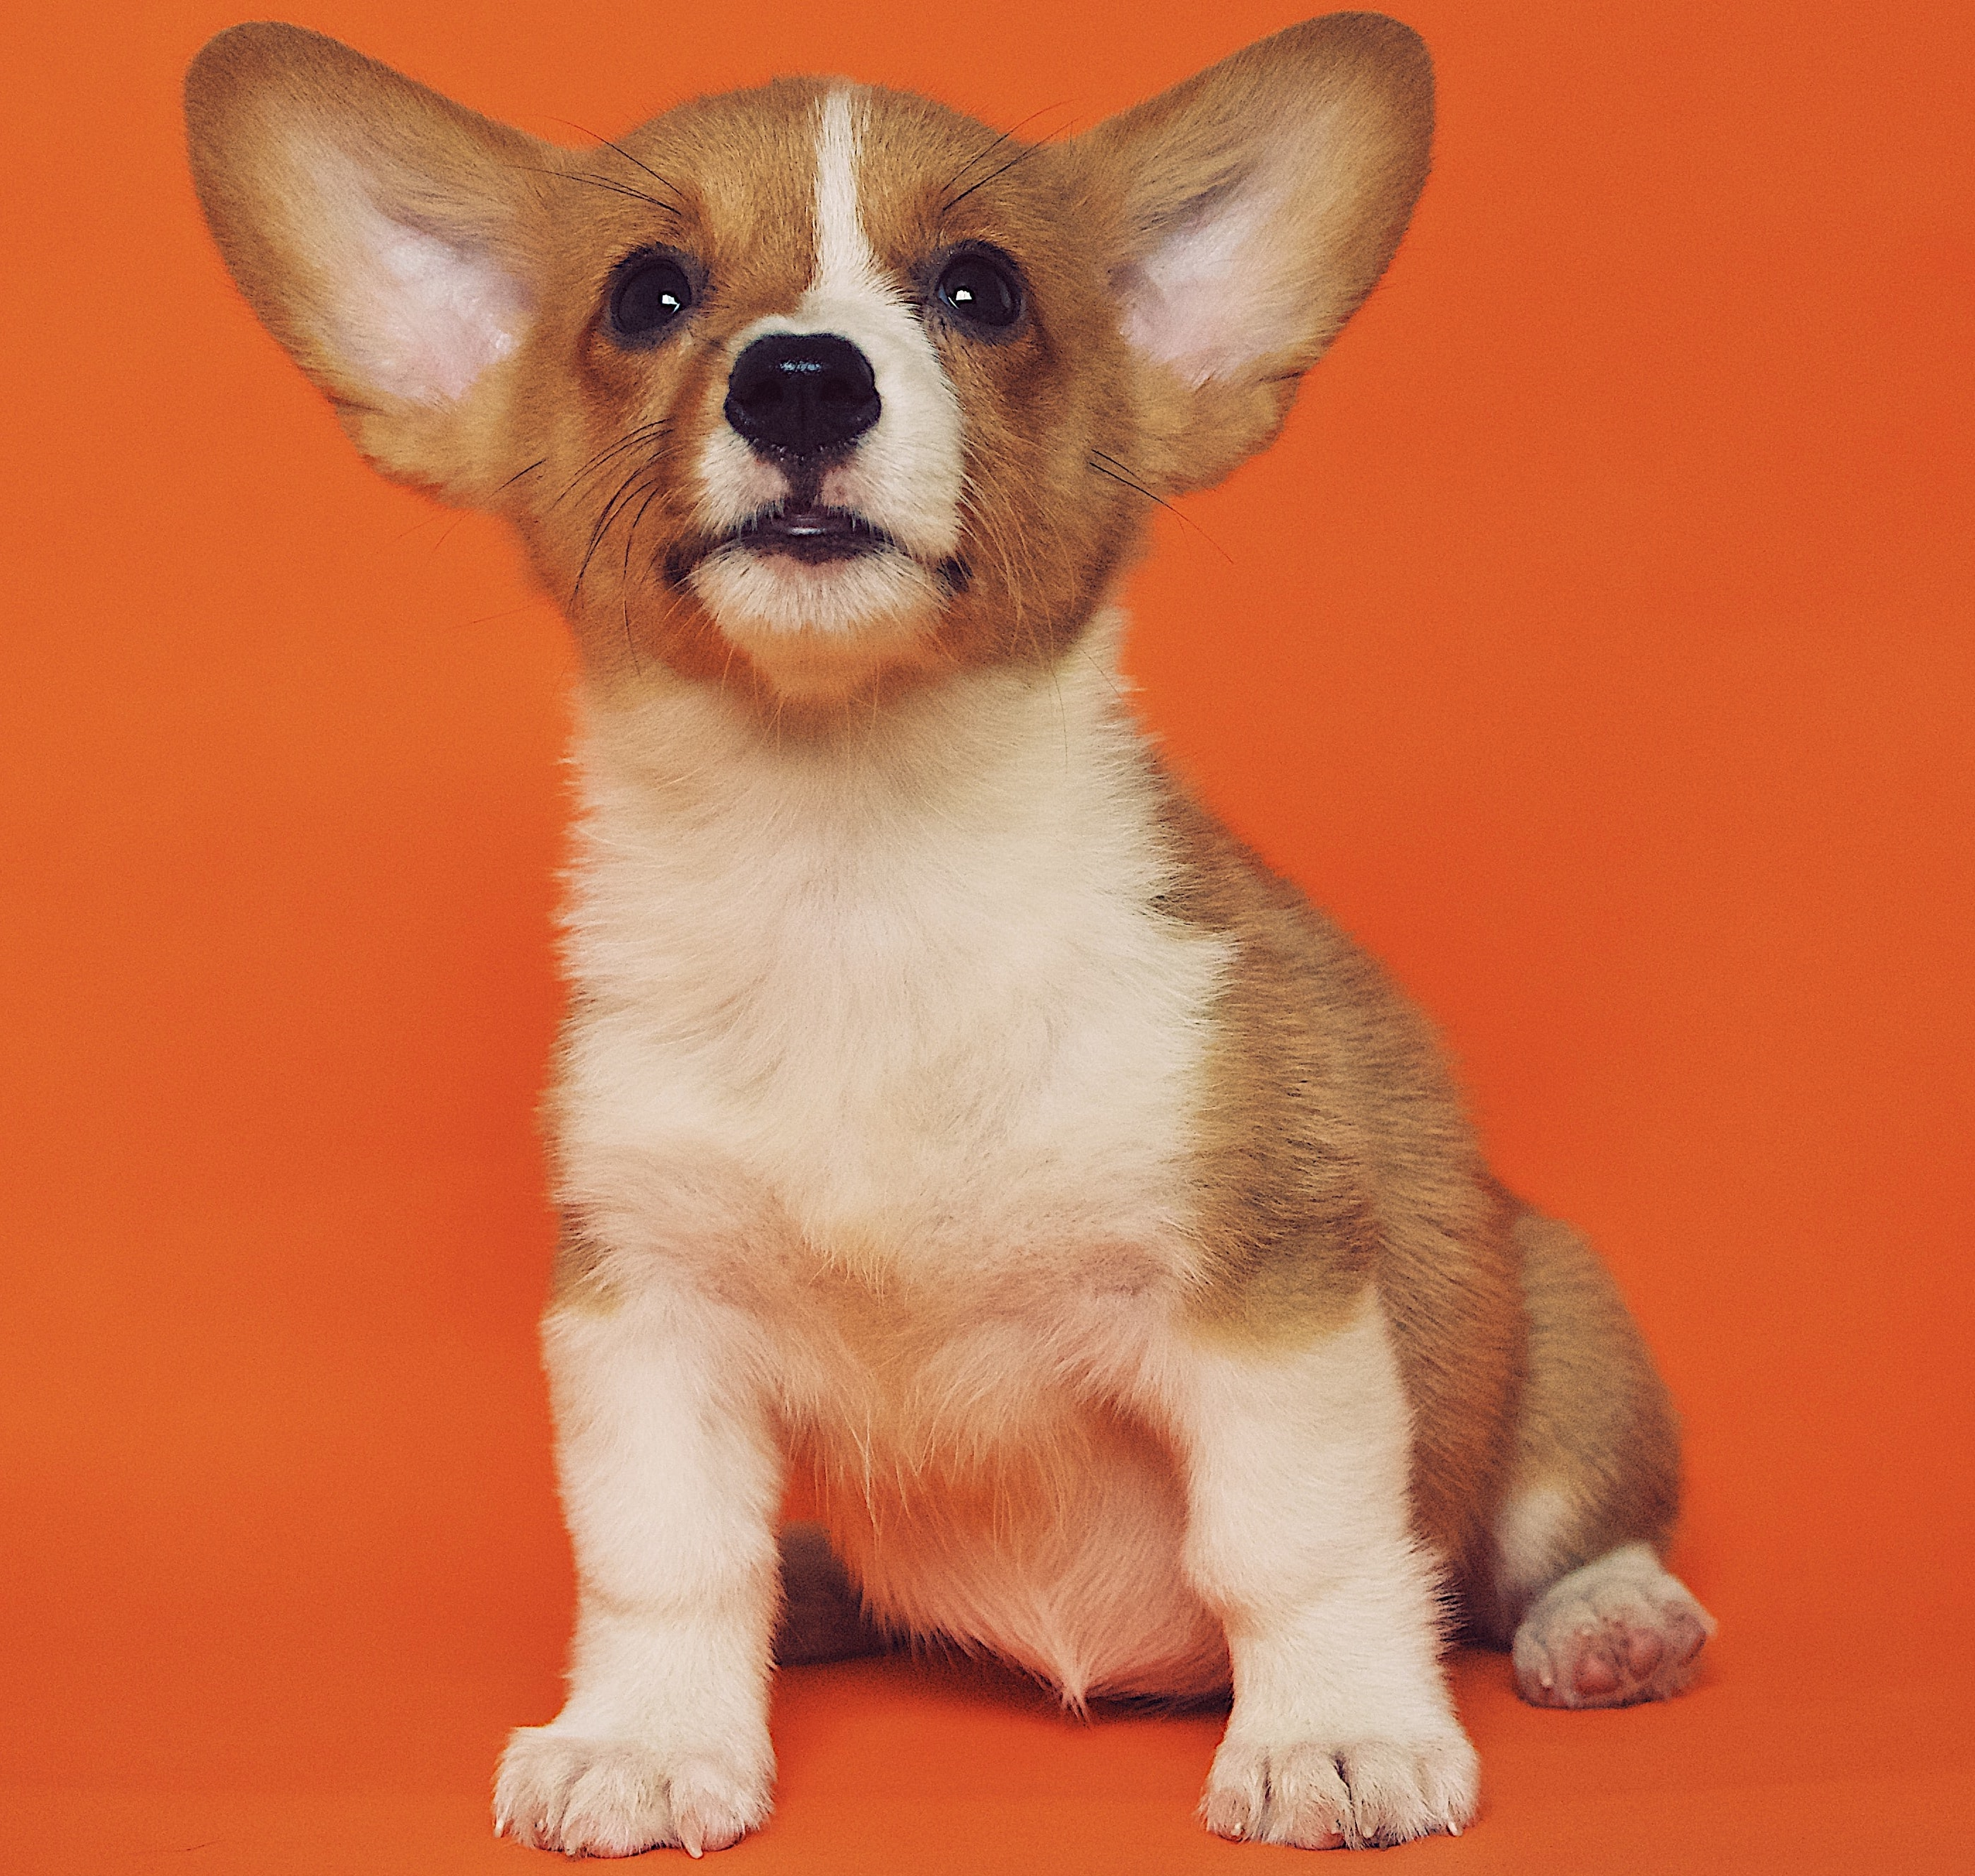

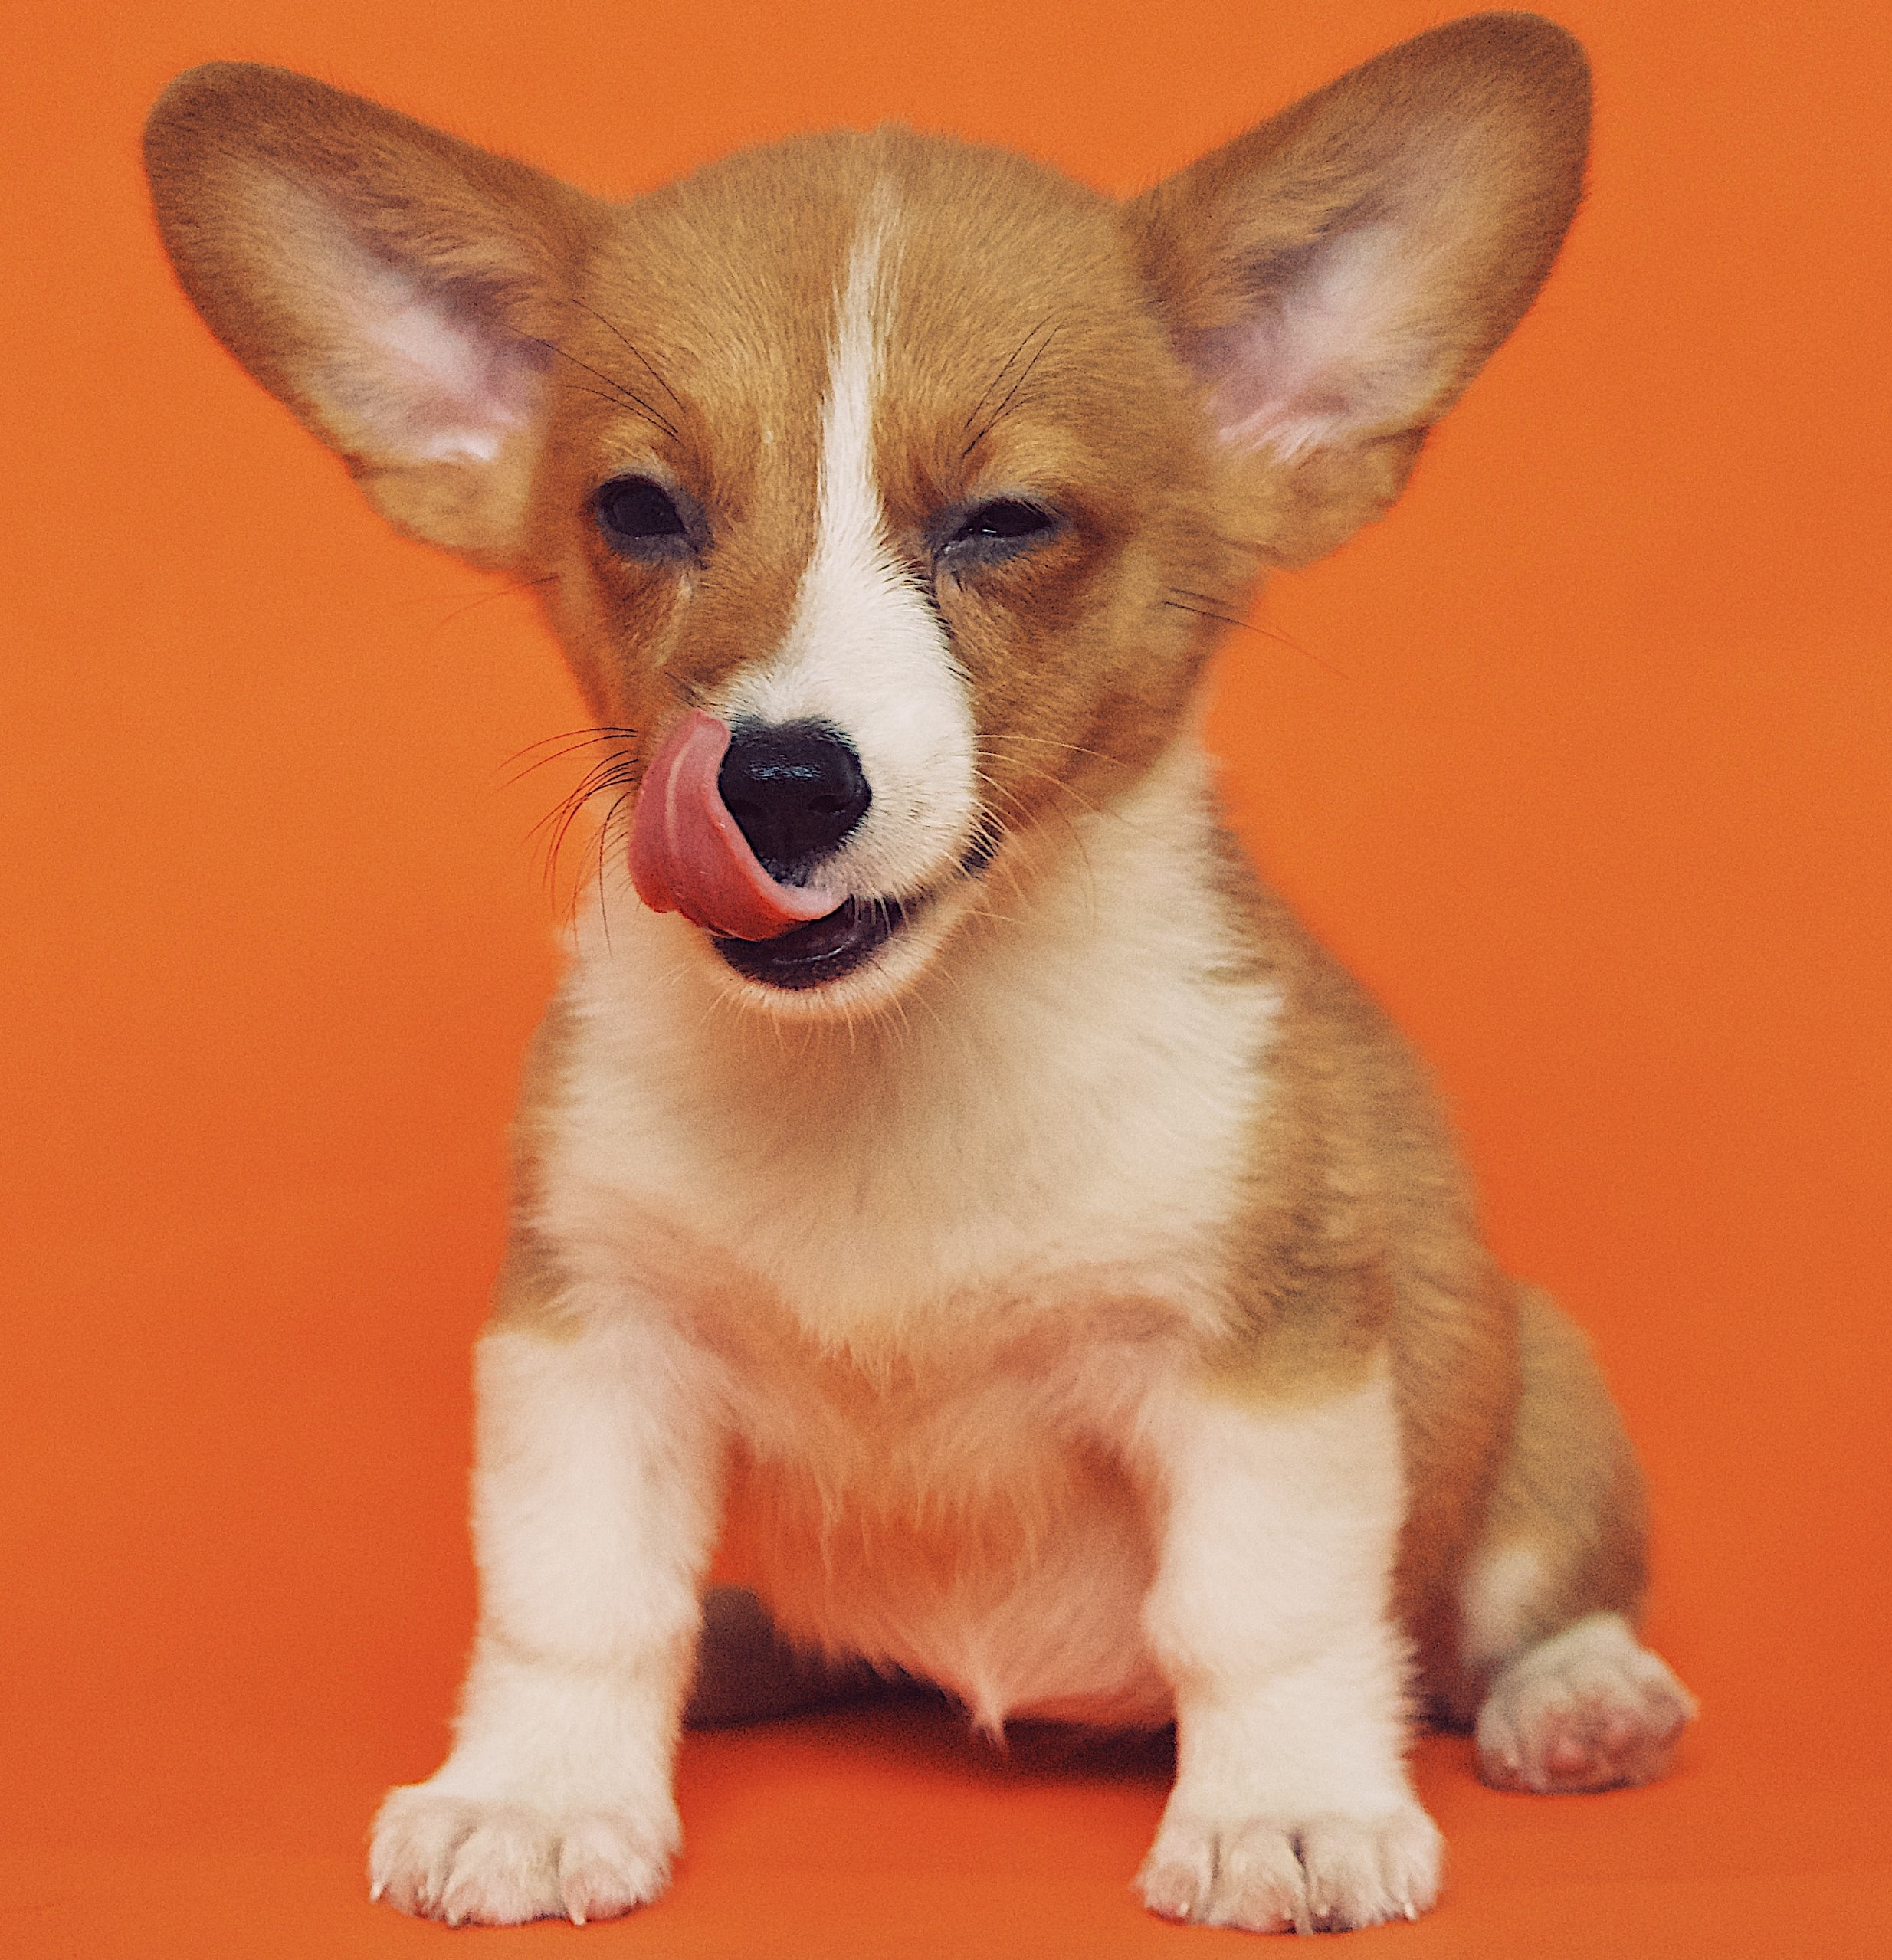

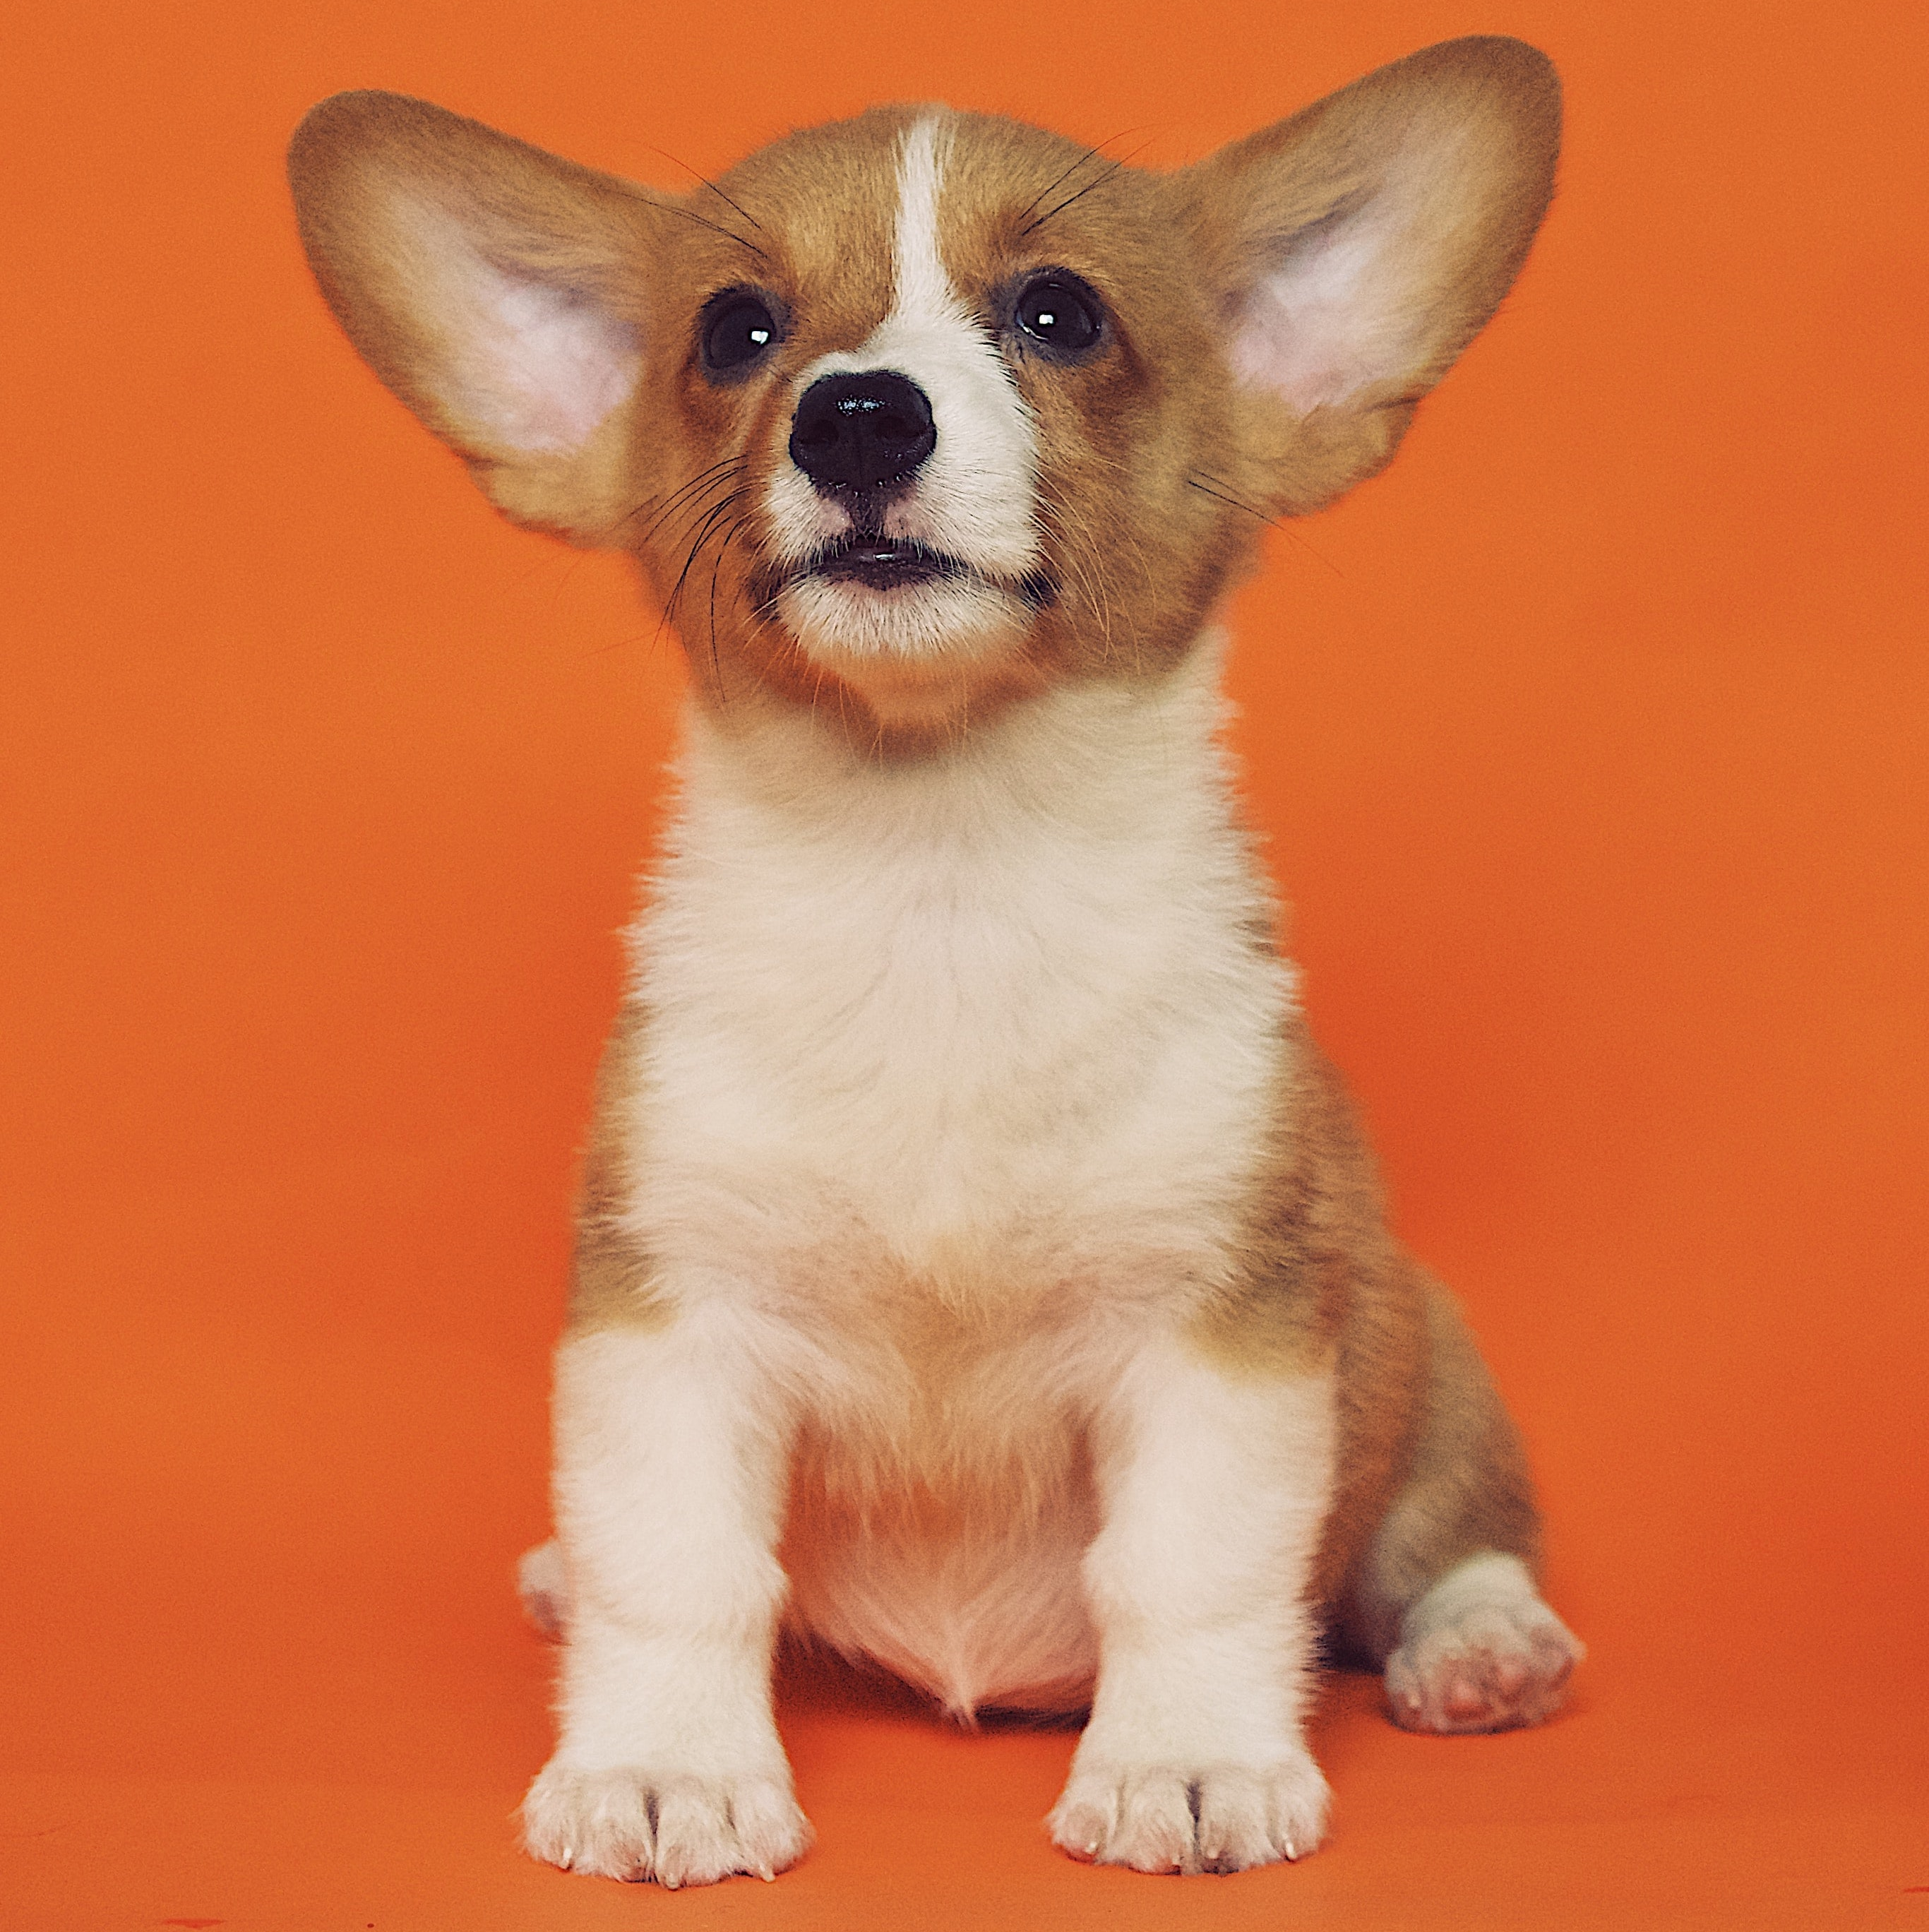

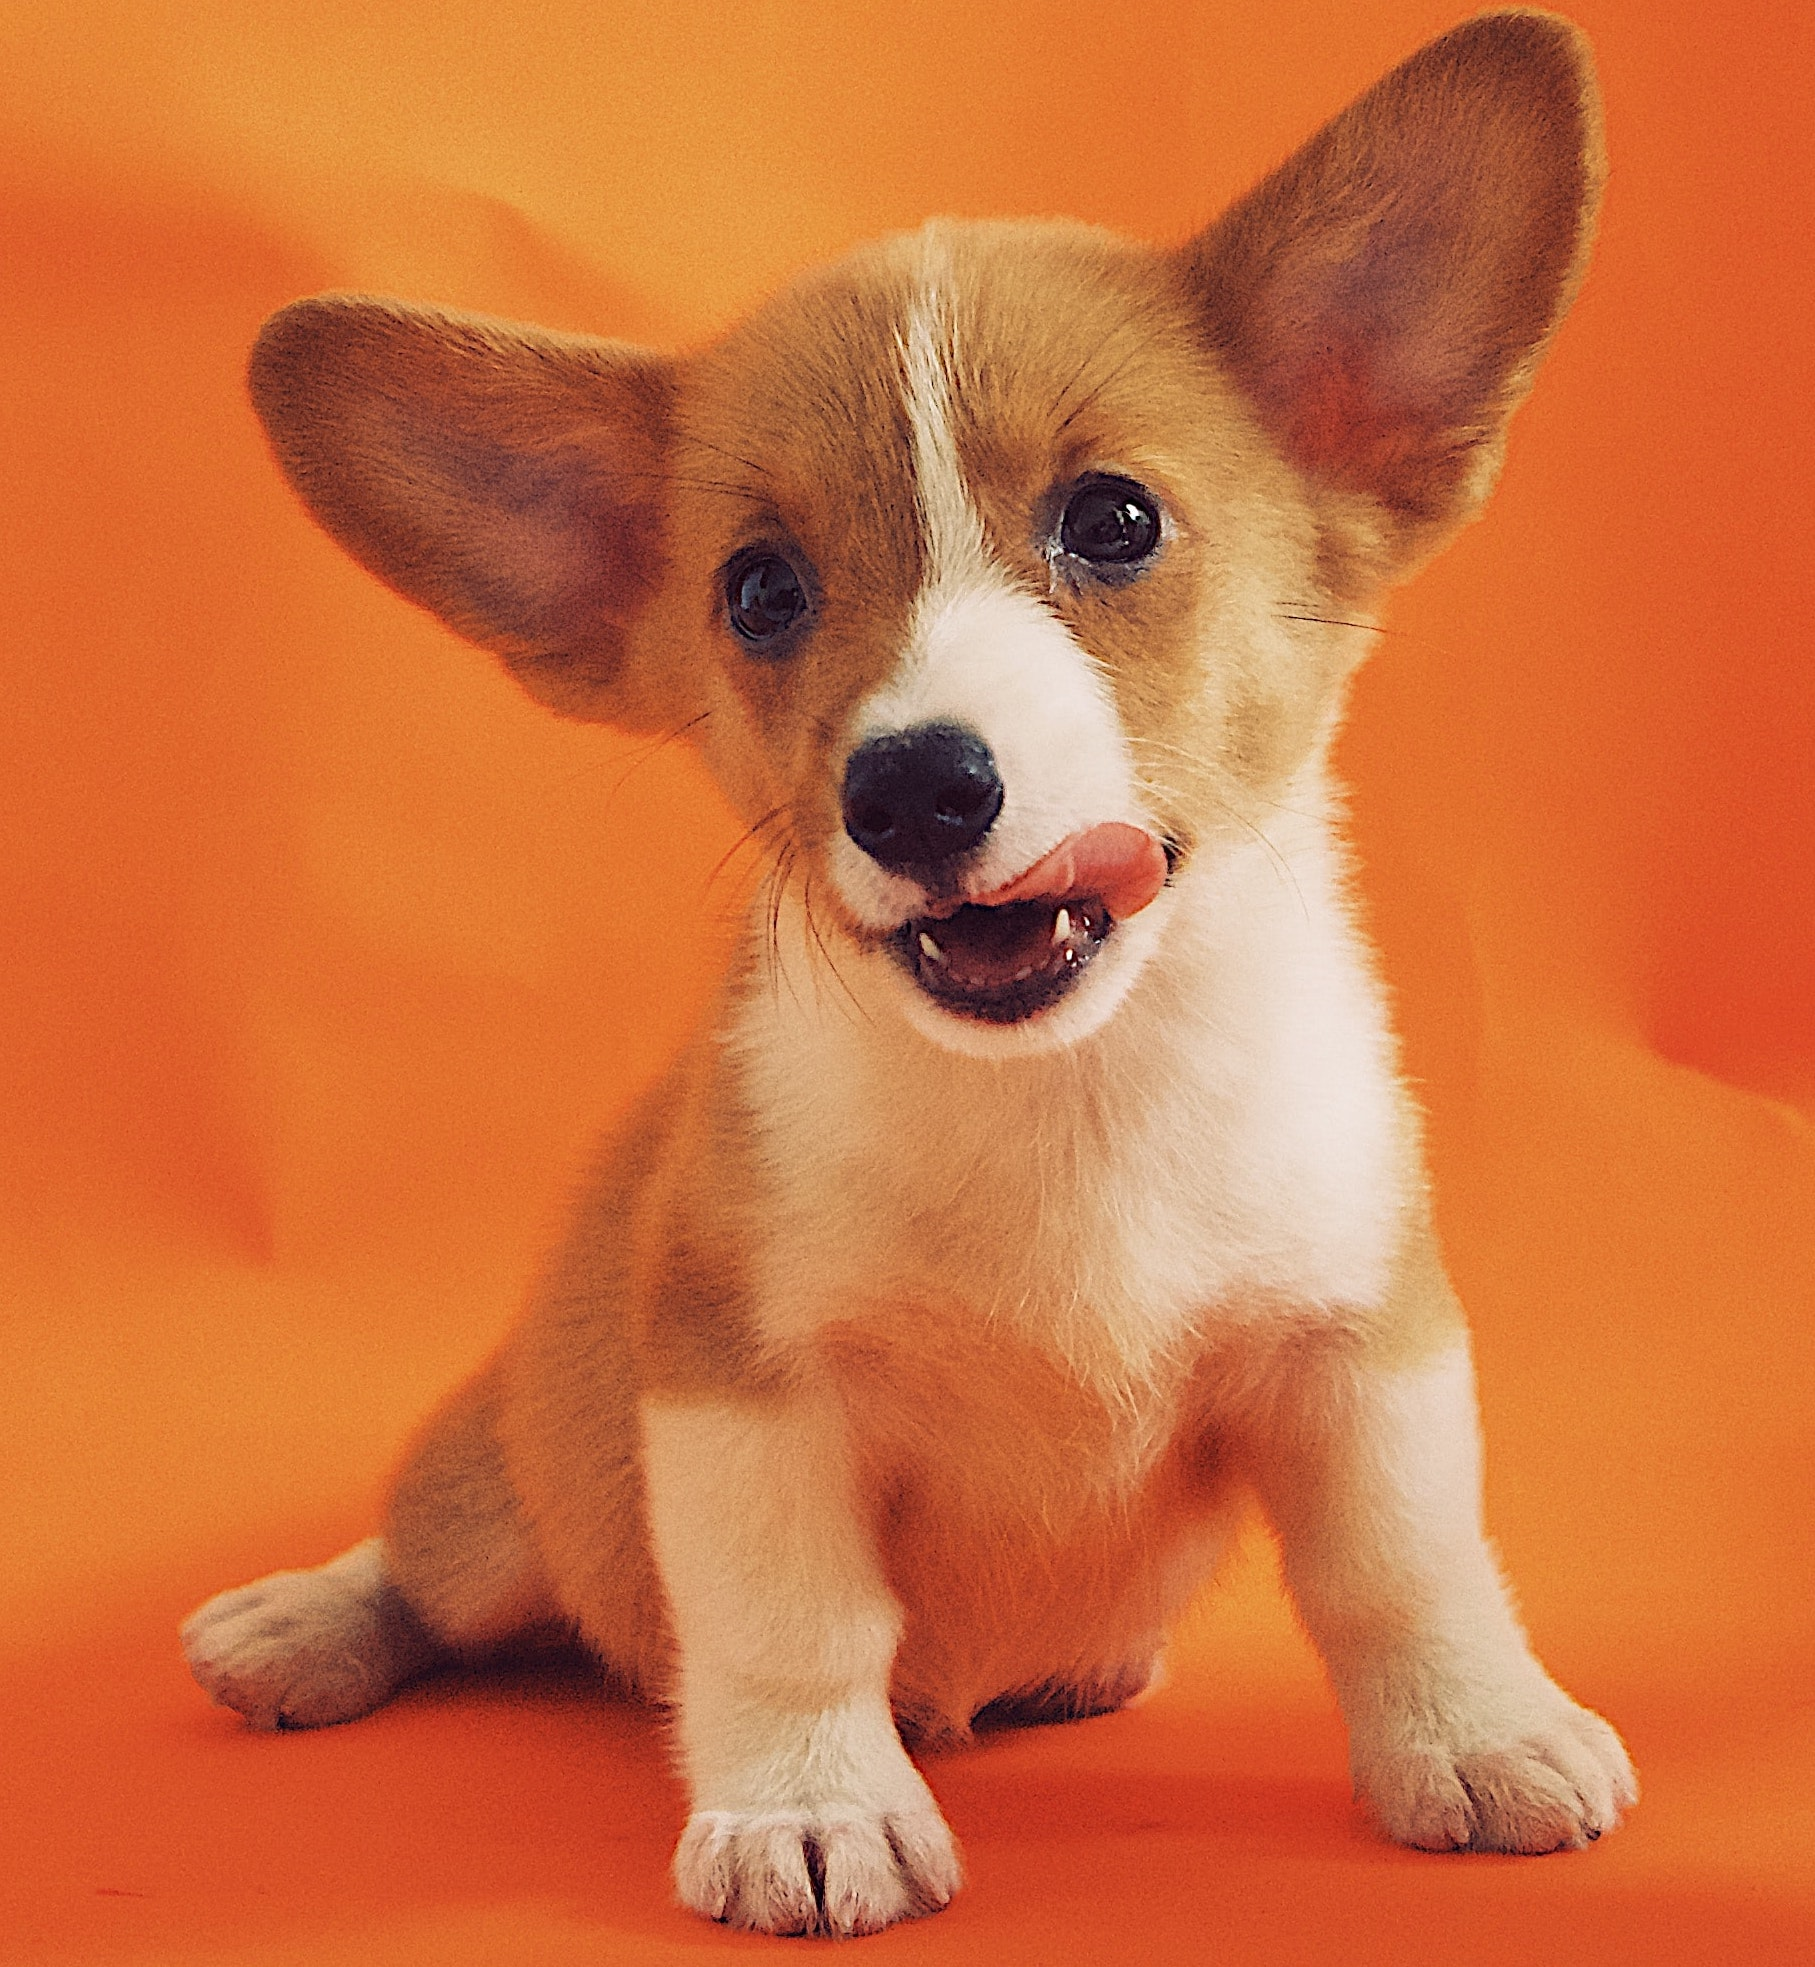

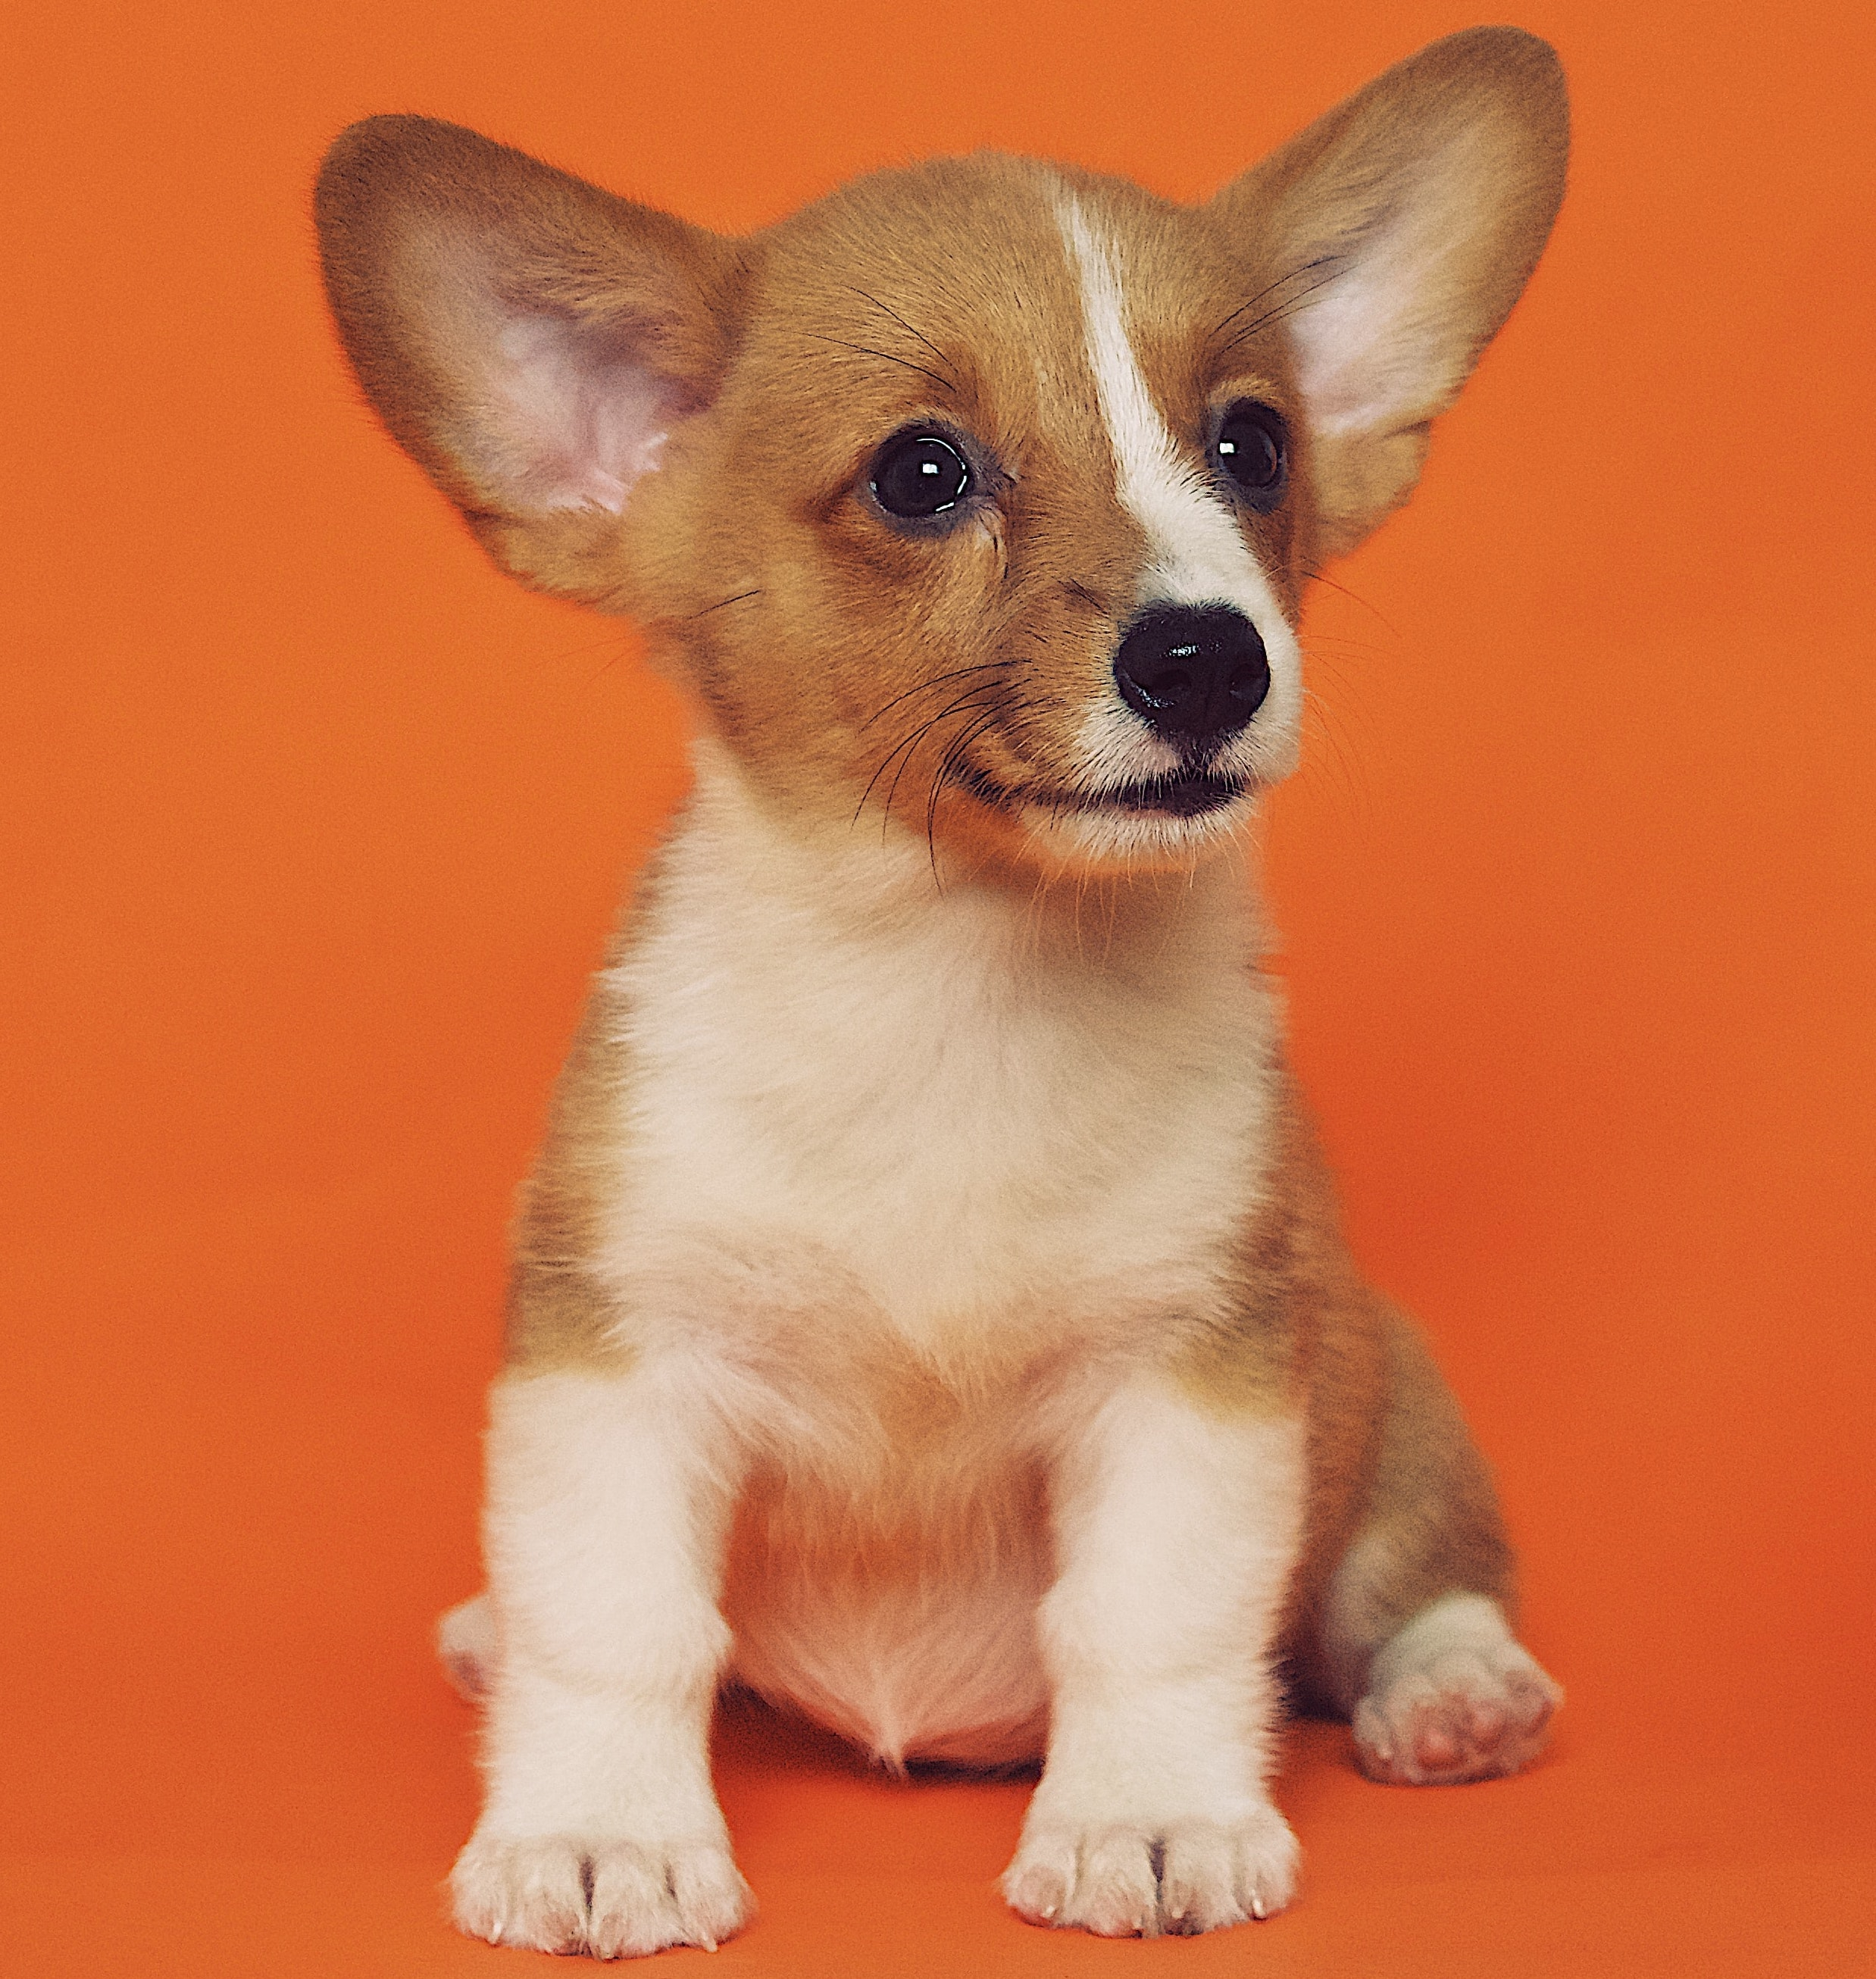

In [3]:
from IPython.display import Image, display
from pathlib import Path

display(*[Image(filename=image_path, width=250) for image_path in Path(SUBJECT_IMAGES_DIR).iterdir()])

Let's come up with some prompts to test our model on after fine-tuning. Notice the `{SUBJECT_TOKEN} {SUBJECT_CLASS}` included in each of them.

You can change these to be more fitting for your subject.

In [13]:
PROMPTS = [
    f"{SUBJECT_TOKEN} {SUBJECT_CLASS} at the beach",
    f"{SUBJECT_TOKEN} {SUBJECT_CLASS} in a bucket",
    f"{SUBJECT_TOKEN} {SUBJECT_CLASS} sleeping soundly",
    f"{SUBJECT_TOKEN} {SUBJECT_CLASS} as a superhero",
]
PROMPTS

['sks dog at the beach',
 'sks dog in a bucket',
 'sks dog sleeping soundly',
 'sks dog as a superhero in a cartoon art style']

## Step 3: Run fine-tuning with Ray Train + HuggingFace Accelerate

Next, let's launch the distributed fine-tuning job.

We will use the training script provided by the [HuggingFace diffusers Dreambooth fine-tuning example](https://github.com/huggingface/diffusers/blob/d7634cca87641897baf90f5a006f2d6d16eac6ec/examples/dreambooth/README_sdxl.md) with very slight modifications.

See `train_dreambooth_lora_sdxl.py` for the training script. The example does fine-tuning with [Low Rank Adaptation](https://arxiv.org/abs/2106.09685) (LoRA), which is a method that freezes most layers but injects a small set of trainable layers that get added to existing layers. This method greatly reduces the amount of training state in GPU memory and reduces the checkpoint size, while maintaining the fine-tuned model quality.

This script is built on HuggingFace Accelerate, and we will show how easy it is to run an existing training script on a Ray cluster with Ray Train.

### Parse training arguments

The `diffusers` script is originally launched via the command line. Here, we'll launch it with Ray Train instead and pass in the parsed command line arguments, in order to make as few modifications to the training script as possible.

In [5]:
import os
from train_dreambooth_lora_sdxl import parse_args

# [Optional] Setup wandb to visualize generated samples during fine-tuning.
# os.environ["WANDB_API_KEY"] = "YOUR_WANDB_API_KEY"
os.environ["WANDB_API_KEY"] = "afee4ae3e5b07d9f76117a8ad9c62e930cd7a63d"

# See `parse_args` in train_dreambooth_lora_sdxl.py to see all the possible configurations.
cmd_line_args = [
    f"--pretrained_model_name_or_path=stabilityai/stable-diffusion-xl-base-1.0",
    f"--pretrained_vae_model_name_or_path=madebyollin/sdxl-vae-fp16-fix",
    f"--instance_data_dir={SUBJECT_IMAGES_DIR}",
    "--output_dir=/mnt/local_storage/lora-trained-xl",
    "--mixed_precision=fp16",
    # A neutral prompt that serves as the caption for the subject image during training.
    f"--instance_prompt=a photo of {SUBJECT_TOKEN} {SUBJECT_CLASS}",
    "--resolution=1024",
    "--train_batch_size=2",
    "--gradient_accumulation_steps=1",
    "--learning_rate=1e-4",
    "--lr_scheduler=constant",
    "--lr_warmup_steps=0",
    "--max_train_steps=80",
    "--checkpointing_steps=80",
    # Use the first prompt as a sample to generate during training.
    f"--validation_prompt={PROMPTS[0]}",
    "--validation_epochs=20",
    "--seed=0",
] + (["--report_to=wandb"] if os.environ.get("WANDB_API_KEY") else [])

TRAINING_ARGS = parse_args(input_args=cmd_line_args)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

2024-03-22 11:51:46.371986: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2024-03-22 11:51:46.372238: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2024-03-22 11:51:46.372244: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


### Launch distributed training with Ray Train

To run distributed training, we'll use a `ray.train.torch.TorchTrainer` to request GPU workers and connect them together in a distributed worker group. Then, when the workers run the training script, HuggingFace Accelerate detects this distributed process group and sets up the model to do data parallel training.

A few notes:
* `ray.init(runtime_env={"env_vars": ...})` sets the environment variables on all workers in the cluster -- setting the environment variable in this notebook on the head node is not enough in a distributed setting.
* `train_fn_per_worker` is the function that will run on all distributed training workers. In this case, it's just a light wrapper on top of the `diffusers` example script that copies the latest checkpoint to shared cluster storage.
* `ScalingConfig` is the configuration that determines how many workers and what kind of accelerator to use for training. Once the training is launched, **Anyscale will automatically scale up nodes to meet this resource request!**

The result of this fine-tuning will be a fine-tuned LoRA model checkpoint at `MODEL_CHECKPOINT_PATH`.

In [6]:
MODEL_CHECKPOINT_PATH = "/mnt/cluster_storage/checkpoint-final"

In [7]:
import os
import shutil

import ray.train
from ray.train.torch import TorchTrainer

from train_dreambooth_lora_sdxl import main


# Set the HuggingFace model cache to a shared location
# so that model loading time is faster after the first time.
os.environ["HF_HOME"] = "/mnt/cluster_storage/hf_cache"

# Set environment variables across the entire cluster.
ray.init(
    runtime_env={
        "env_vars": {
            "HF_HOME": os.environ.get("HF_HOME"),
            "WANDB_API_KEY": os.environ.get("WANDB_API_KEY"),
        }
    },
    ignore_reinit_error=True,
)


def train_fn_per_worker(config: dict):
    # See train_dreambooth_lora_sdxl.py for all of the training details.
    final_checkpoint_path = main(config["args"])

    if final_checkpoint_path is not None:
        destination_path = config["model_checkpoint_path"]
        shutil.copytree(final_checkpoint_path, destination_path, dirs_exist_ok=True)
        print(f"Copied the checkpoint to {destination_path} for later use!")


trainer = TorchTrainer(
    train_fn_per_worker,
    train_loop_config={
        # Pass command line arguments from the driver to the `config` dict of the `train_fn_per_worker`
        "args": TRAINING_ARGS,
        # This is where we can access the fine-tuned model checkpoint later.
        "model_checkpoint_path": MODEL_CHECKPOINT_PATH,
    },
    scaling_config=ray.train.ScalingConfig(
        # Do data parallel training with A10G GPU workers
        num_workers=4, use_gpu=True, accelerator_type="A10G"
    ),
)


2024-03-22 11:51:53,106	INFO worker.py:1567 -- Connecting to existing Ray cluster at address: 10.0.12.66:6379...
2024-03-22 11:51:53,113	INFO worker.py:1743 -- Connected to Ray cluster. View the dashboard at https://session-86yp63qukxhw4893rlzd8nbz8y.i.anyscaleuserdata-staging.com 
2024-03-22 11:51:53,132	INFO packaging.py:358 -- Pushing file package 'gcs://_ray_pkg_331ede125001531cc799d4350eeb85dbd9d2cbf4.zip' (7.29MiB) to Ray cluster...
2024-03-22 11:51:53,161	INFO packaging.py:371 -- Successfully pushed file package 'gcs://_ray_pkg_331ede125001531cc799d4350eeb85dbd9d2cbf4.zip'.


In [8]:
# Launch the training.
trainer.fit()

(autoscaler +4s) Tip: use `ray status` to view detailed cluster status. To disable these messages, set RAY_SCHEDULER_EVENTS=0.
(autoscaler +4s) [autoscaler] [8xA10G:192CPU-768GB] Upscaling 1 node(s) to satisfy gang resource requests.
(autoscaler +5s) [autoscaler] [4xA10G:48CPU-192GB|g5.12xlarge] [us-west-2a] [on-demand] Launched 1 instances.
(autoscaler +52s) [autoscaler] Cluster upscaled to {56 CPU, 4 GPU}.


(TrainTrainable pid=3255, ip=10.0.3.83) 2024-03-22 11:53:06.425569: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
(TrainTrainable pid=3255, ip=10.0.3.83) 2024-03-22 11:53:06.425922: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
(TrainTrainable pid=3255, ip=10.0.3.83) 2024-03-22 11:53:06.425931: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed p

(RayTrainWorker pid=3401, ip=10.0.3.83) [2024-03-22 11:55:28,879] [INFO] [real_accelerator.py:158:get_accelerator] Setting ds_accelerator to cuda (auto detect)


(RayTrainWorker pid=3401, ip=10.0.3.83) {'image_encoder', 'feature_extractor'} was not found in config. Values will be initialized to default values.
(RayTrainWorker pid=3401, ip=10.0.3.83) 
Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]{'sigma_min', 'sigma_max', 'rescale_betas_zero_snr', 'timestep_type'} was not found in config. Values will be initialized to default values.
(RayTrainWorker pid=3401, ip=10.0.3.83) Loaded scheduler as EulerDiscreteScheduler from `scheduler` subfolder of stabilityai/stable-diffusion-xl-base-1.0.
(RayTrainWorker pid=3401, ip=10.0.3.83) Loaded tokenizer as CLIPTokenizer from `tokenizer` subfolder of stabilityai/stable-diffusion-xl-base-1.0.
(RayTrainWorker pid=3401, ip=10.0.3.83) 
Loading pipeline components...:  71%|███████▏  | 5/7 [00:00<00:00, 44.31it/s]
(RayTrainWorker pid=3401, ip=10.0.3.83) Loaded tokenizer_2 as CLIPTokenizer from `tokenizer_2` subfolder of stabilityai/stable-diffusion-xl-base-1.0.
Loading pipeline components..

(RayTrainWorker pid=3401, ip=10.0.3.83) Copied the checkpoint to /mnt/cluster_storage/checkpoint-final for later use!


(RayTrainWorker pid=3401, ip=10.0.3.83) Exception in thread SockSrvRdThr:
(RayTrainWorker pid=3401, ip=10.0.3.83) Traceback (most recent call last):
(RayTrainWorker pid=3401, ip=10.0.3.83)   File "/home/ray/anaconda3/lib/python3.9/threading.py", line 980, in _bootstrap_inner
(RayTrainWorker pid=3401, ip=10.0.3.83)     self.run()
(RayTrainWorker pid=3401, ip=10.0.3.83)   File "/home/ray/anaconda3/lib/python3.9/site-packages/wandb/sdk/service/server_sock.py", line 112, in run
(RayTrainWorker pid=3401, ip=10.0.3.83)     shandler(sreq)
(RayTrainWorker pid=3401, ip=10.0.3.83)   File "/home/ray/anaconda3/lib/python3.9/site-packages/wandb/sdk/service/server_sock.py", line 173, in server_record_publish
(RayTrainWorker pid=3401, ip=10.0.3.83)     iface = self._mux.get_stream(stream_id).interface
(RayTrainWorker pid=3401, ip=10.0.3.83)   File "/home/ray/anaconda3/lib/python3.9/site-packages/wandb/sdk/service/streams.py", line 199, in get_stream
(RayTrainWorker pid=3401, ip=10.0.3.83)     stream 

Trial TorchTrainer_3fda9_00000 completed. Last result: 


2024-03-22 12:05:38,408	INFO tune.py:1048 -- Total run time: 824.92 seconds (824.37 seconds for the tuning loop).


Result(
  metrics={},
  path='/home/ray/ray_results/TorchTrainer_2024-03-22_11-51-53/TorchTrainer_3fda9_00000_0_2024-03-22_11-51-54',
  filesystem='local',
  checkpoint=None
)

## Step 3: Generate some images with your fine-tuned model!

Finally, let's generate some images!

We'll launch 2 remote GPU tasks to generate images from the `PROMPTS` we defined earlier, one using just the base model and one that loads our fine-tuned LoRA weights. Let's compare them to see the results of fine-tuning!

Note: If your cluster has already scaled down from the training job due to the workers being idle, then this step might take a little longer to relaunch new GPU workers.

In [14]:
import ray
from utils import generate

[base_model_images, finetuned_images] = ray.get([
    generate.remote(prompts=PROMPTS, args=TRAINING_ARGS),
    generate.remote(
        prompts=PROMPTS, args=TRAINING_ARGS, model_checkpoint_path=MODEL_CHECKPOINT_PATH
    )
])

(generate pid=7921, ip=10.0.3.83) 2024-03-22 12:10:30.753893: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
(generate pid=7921, ip=10.0.3.83) 2024-03-22 12:10:30.753989: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
(generate pid=7921, ip=10.0.3.83) 2024-03-22 12:10:30.753996: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
Loading p

/mnt/cluster_storage/generated/finetuned=False-2024-03-22_12-10-39/sks_dog_at_the_beach_d8ec.jpg
/mnt/cluster_storage/generated/finetuned=False-2024-03-22_12-10-39/sks_dog_in_a_bucket_2e74.jpg
/mnt/cluster_storage/generated/finetuned=False-2024-03-22_12-10-39/sks_dog_sleeping_soundly_1f56.jpg
/mnt/cluster_storage/generated/finetuned=False-2024-03-22_12-10-39/sks_dog_as_a_superhero_in_a_cartoon_art_style_eab3.jpg


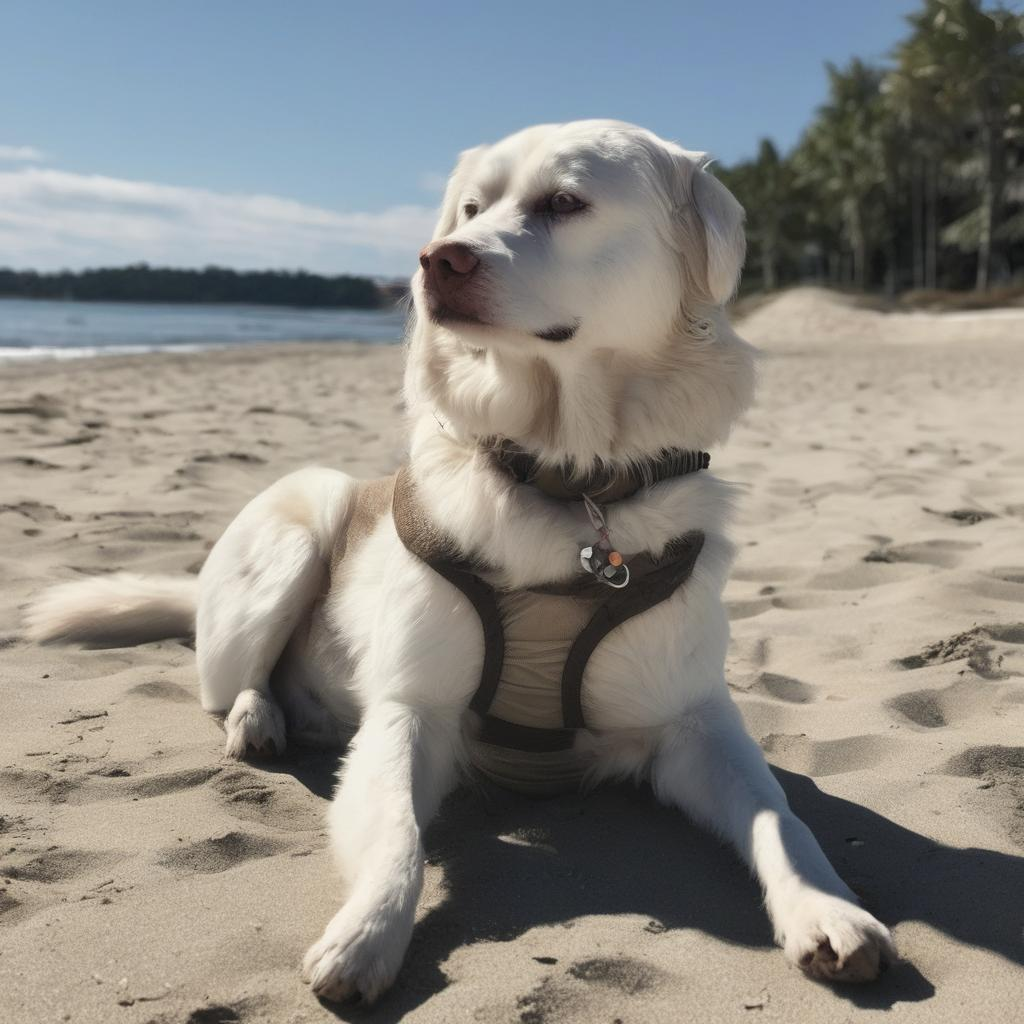

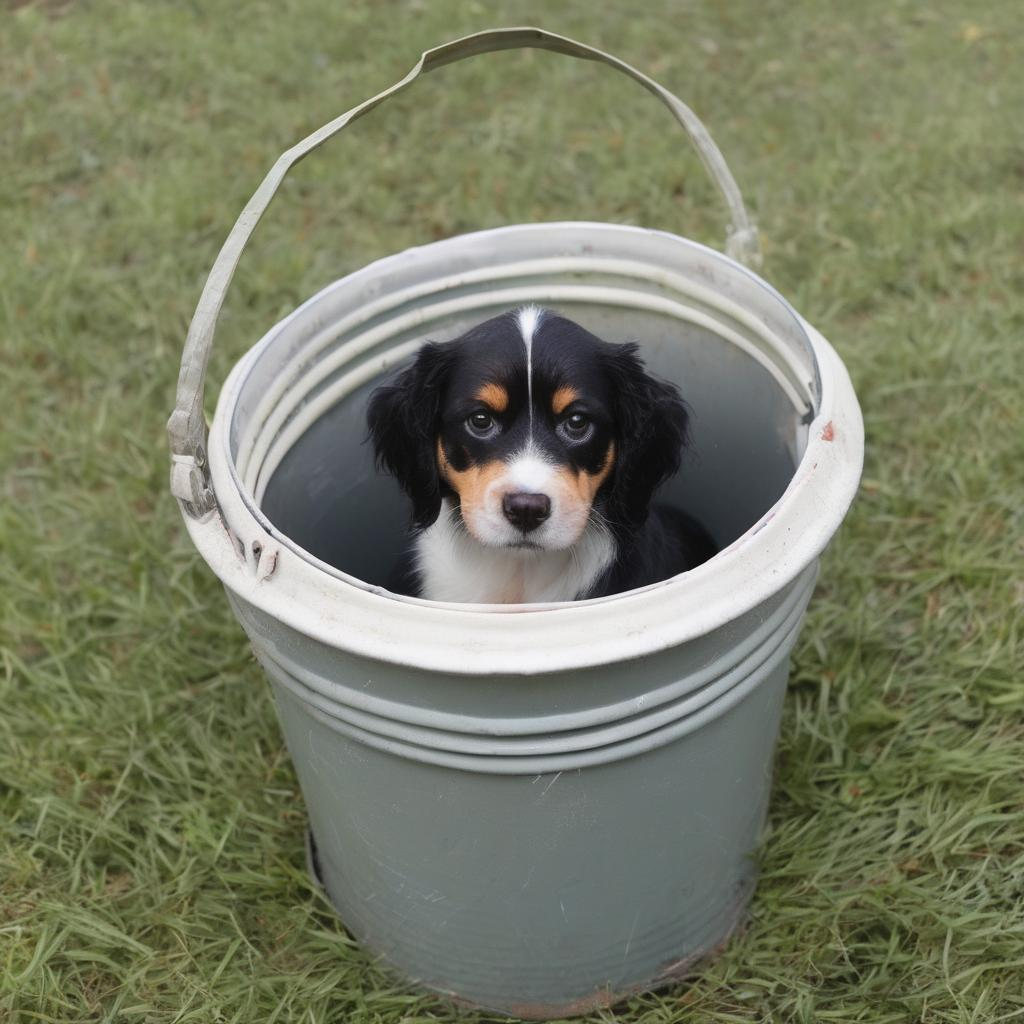

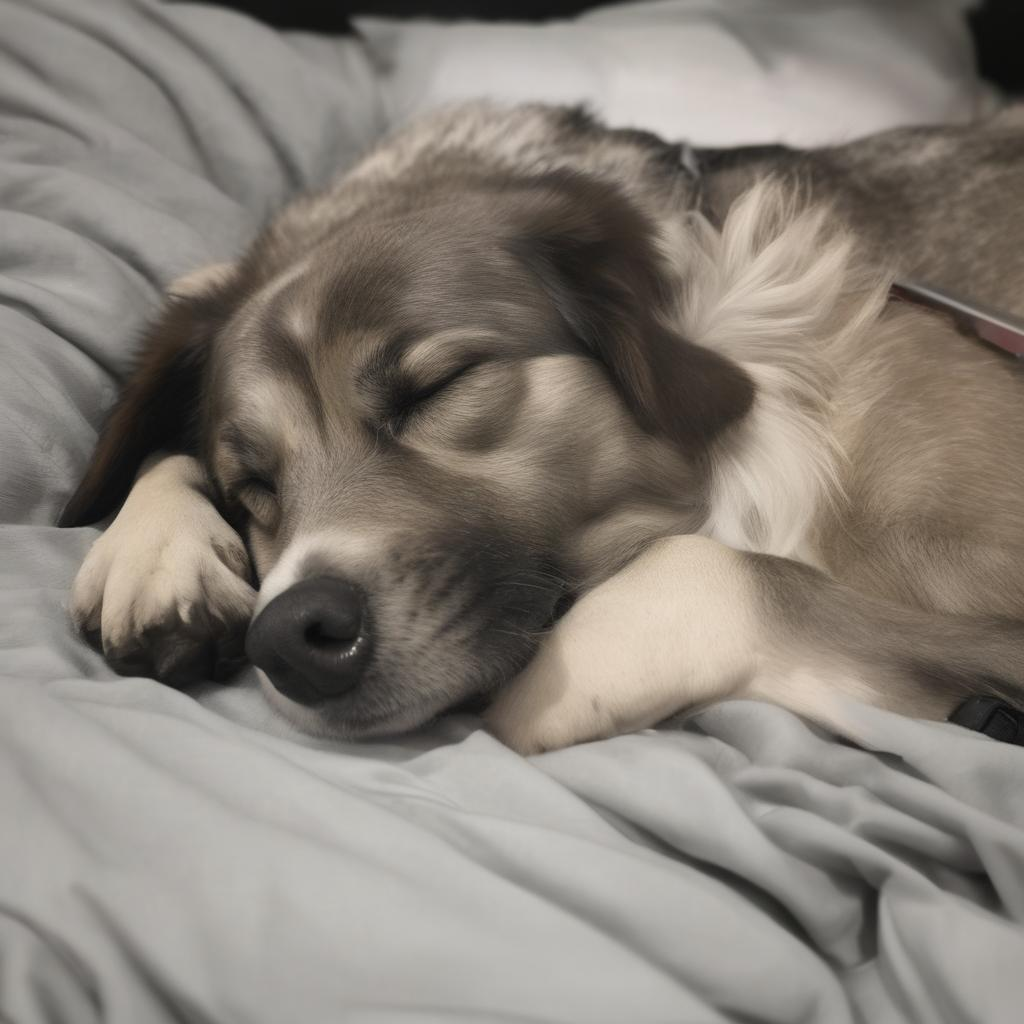

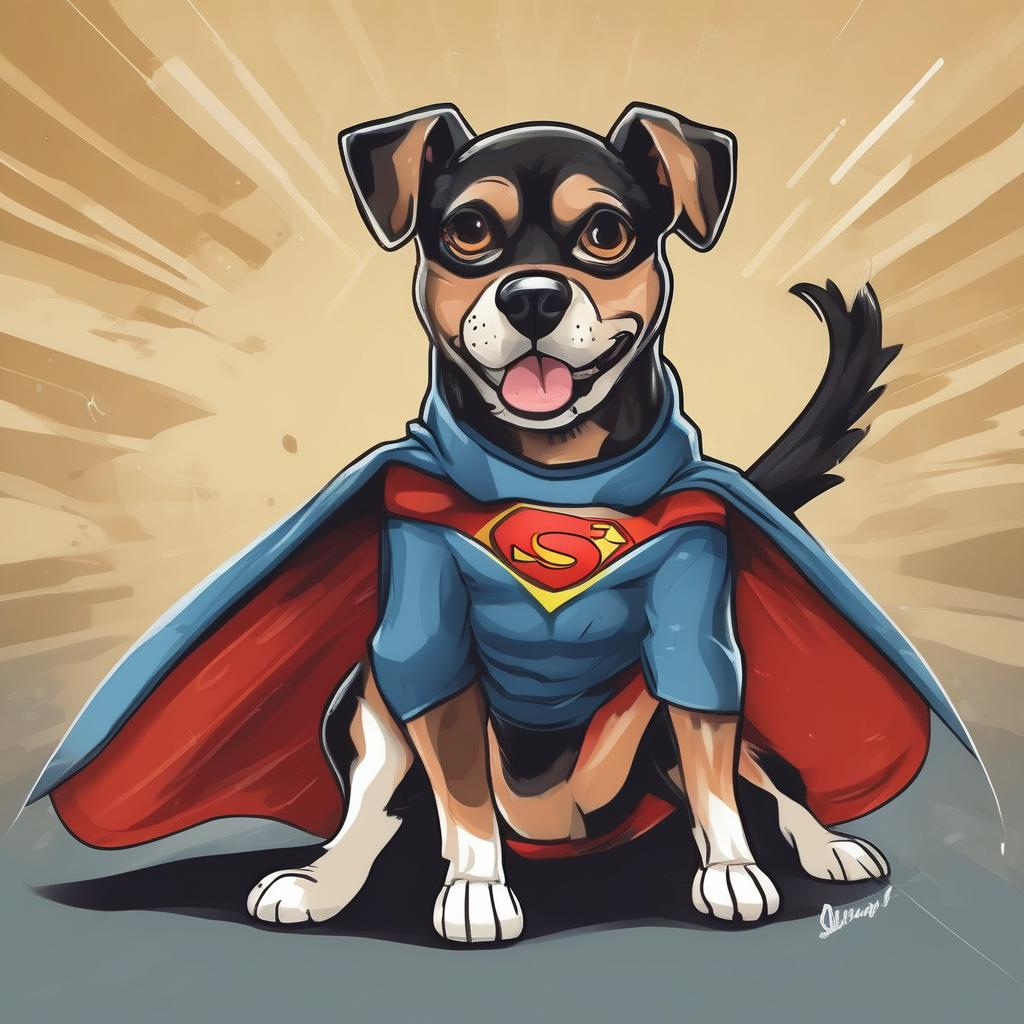

In [15]:
print("\n".join(base_model_images))
display(*[Image(filename=image_path, width=250) for image_path in base_model_images])

/mnt/cluster_storage/generated/finetuned=True-2024-03-22_12-10-39/sks_dog_at_the_beach_52e9.jpg
/mnt/cluster_storage/generated/finetuned=True-2024-03-22_12-10-39/sks_dog_in_a_bucket_4c36.jpg
/mnt/cluster_storage/generated/finetuned=True-2024-03-22_12-10-39/sks_dog_sleeping_soundly_4348.jpg
/mnt/cluster_storage/generated/finetuned=True-2024-03-22_12-10-39/sks_dog_as_a_superhero_in_a_cartoon_art_style_ba48.jpg


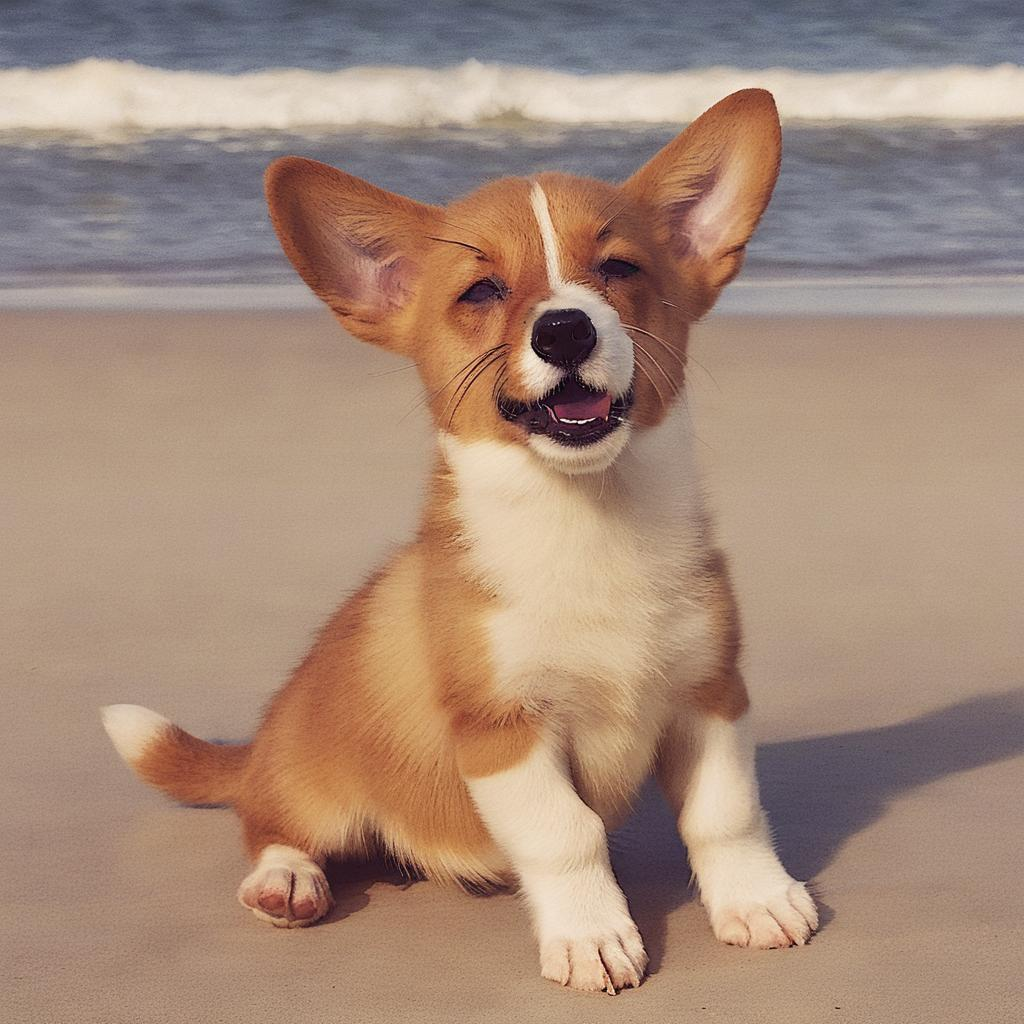

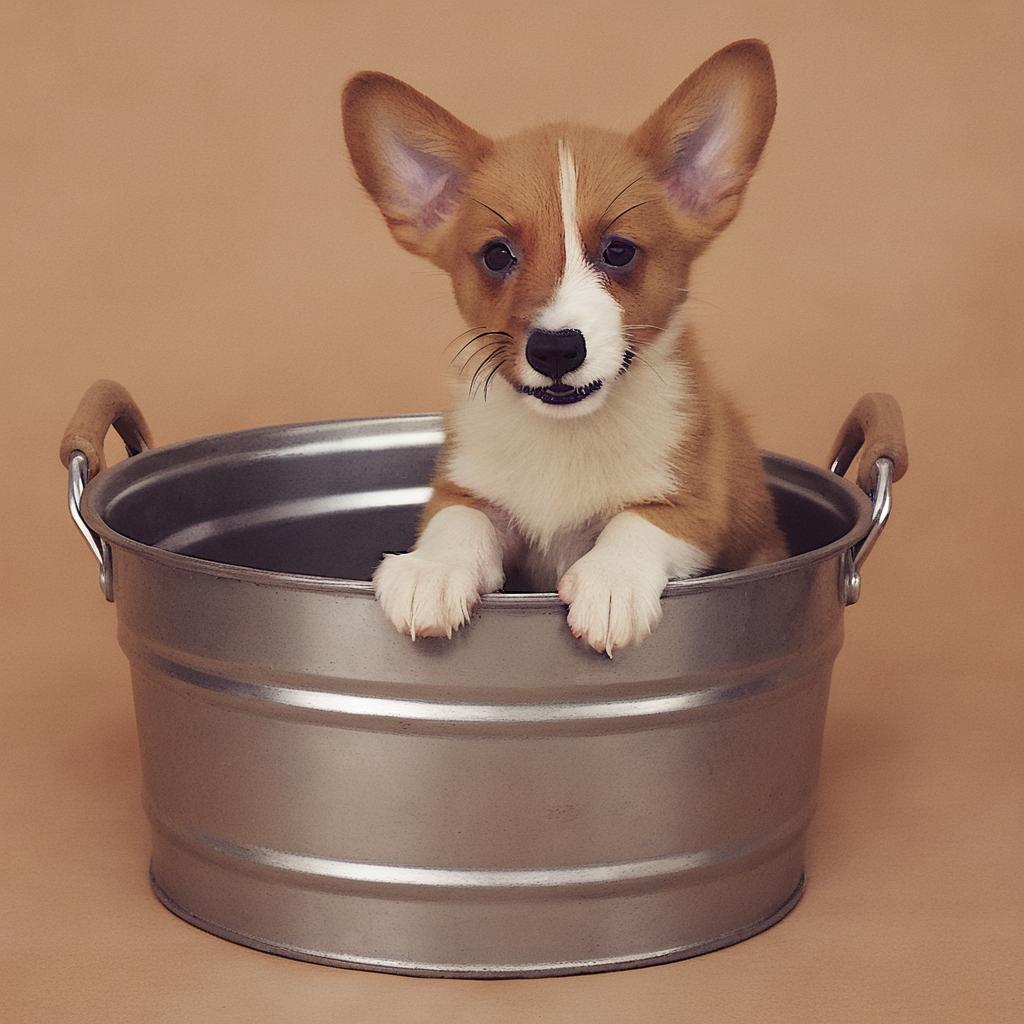

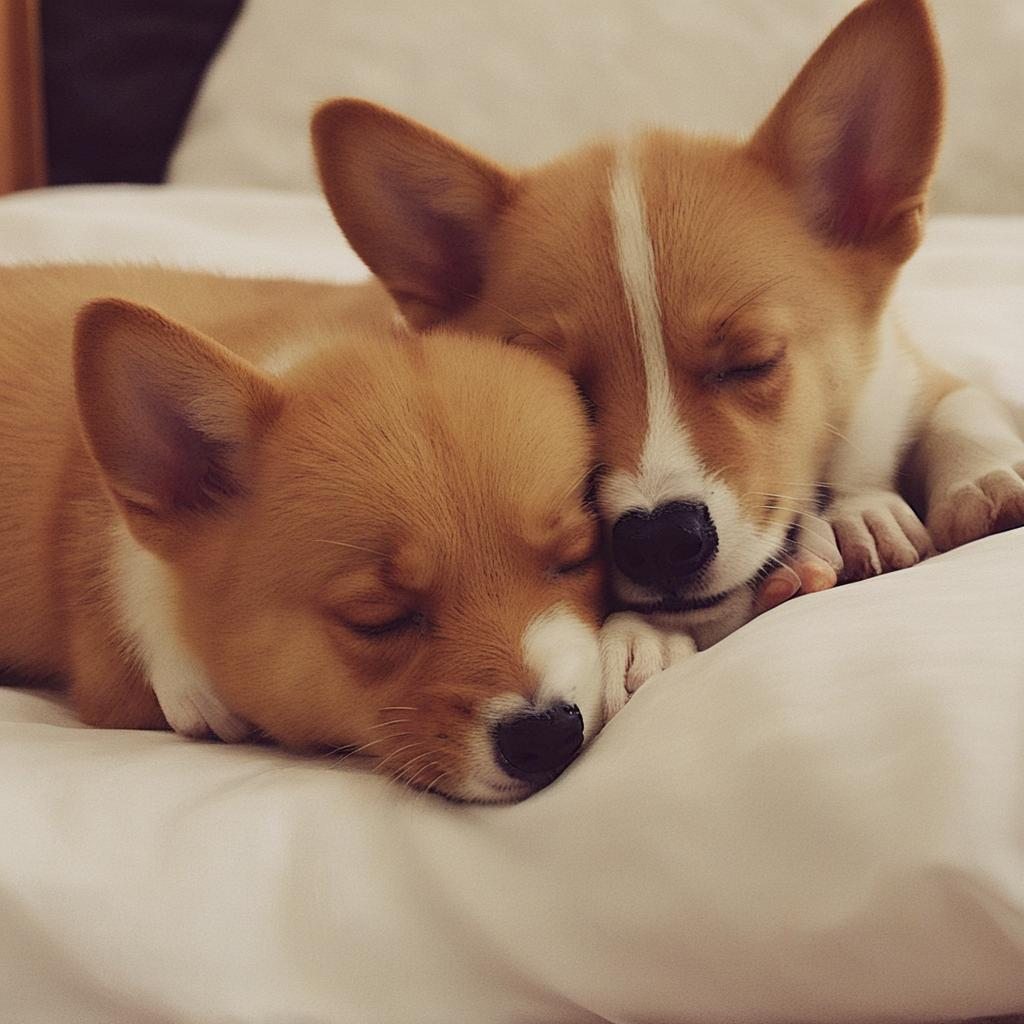

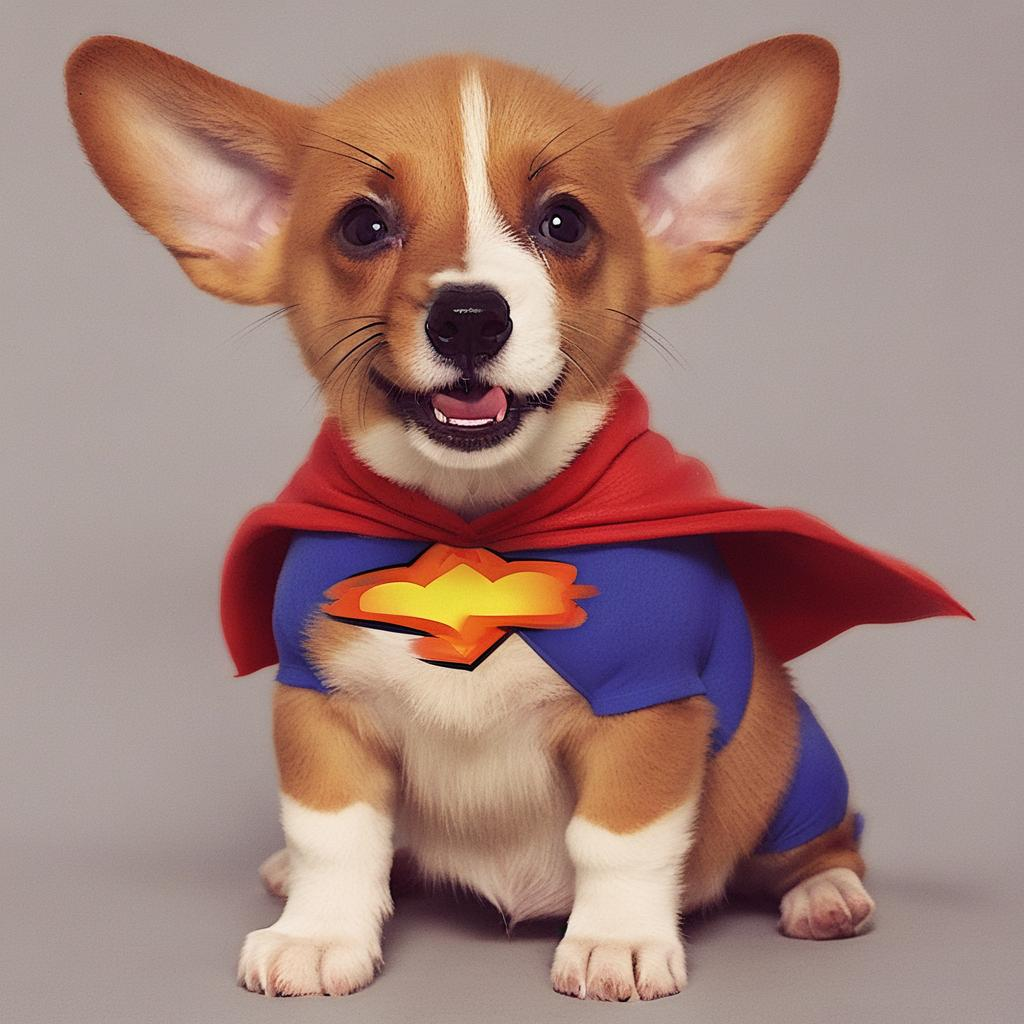

(autoscaler +24m4s) [autoscaler] Downscaling node i-0d5c3c896963585b3 (node IP: 10.0.3.83) due to node idle termination.
(autoscaler +24m5s) [autoscaler] Cluster resized to {8 CPU, 0 GPU}.
(autoscaler +24m19s) Instance i-0d5c3c896963585b3 (node IP: 10.0.3.83) is now failing Ray health checks and may be terminated soon: the Raylet health check on this worker node is failing: check node metrics or 'raylet.[out|err]' for details.


In [16]:
print("\n".join(finetuned_images))
display(*[Image(filename=image_path, width=250) for image_path in finetuned_images])

## Summary

Congrats, you've fine-tuned Stable Diffusion XL!

As a recap, this notebook:
1. Installed cluster-wide dependencies.
2. Scaled out fine-tuning to many GPU workers.
3. Compared the generated output results before and after fine-tuning.

As a next step, you can take the fine-tuned model checkpoint and use it to serve the model. See the tutorial on serving stable diffusion on the home page to get started!